# MuSo Train
MuSo is a supervised machine learning model for predicting user compatibility (degrees of separation) based on their music preferences. This document handles the dataset vectorization, regularization, and model training.

## Initialization and Loading the Dataset

In [1]:
import json
import random
import numpy as np
import pandas as pd
from numpy.typing import NDArray

with open("MuSo_User_Data.json", "r") as f:
    USER_DATA:dict = json.load(f)
    
USER_DOS = pd.read_csv("MuSo_User_DOS.csv", index_col = 0)

if "top_tags" in list(USER_DATA.values())[0]:
    INCL_TAGS = True
    
MAX_DOS = USER_DOS.max().max()
    
print(
    f"""
    Include Tags: {INCL_TAGS}
    Maximum Degree of Separation: {MAX_DOS}
    """
)


    Include Tags: True
    Maximum Degree of Separation: 41
    


## Dataset User Vectorization

In [2]:
def get_unique_top_items(data:dict, top_item:str, shuffled:bool=False)->list[str]:
    all_items = []
    for user in data:
        all_items += list(data[user][top_item].keys())
        
    all_unique_items = list(set(all_items))
    if shuffled:
        random.shuffle(all_unique_items)
    else:
        all_unique_items.sort()
    return all_unique_items


def get_all_unique_top_items(data:dict, include_tags:bool=False):
    do_shuffle = False
    all_artists = get_unique_top_items(data, "top_artists", shuffled=do_shuffle)
    all_albums = get_unique_top_items(data, "top_albums", shuffled=do_shuffle)
    all_tracks = get_unique_top_items(data, "top_tracks", shuffled=do_shuffle)
    if include_tags:
        all_tags = get_unique_top_items(data, "top_tags", shuffled=do_shuffle)
        random.shuffle(all_tags)
    else:
        all_tags = None
    return all_artists, all_albums, all_tracks, all_tags

def get_user_vector_size():
    input_vec_size = 0
    all_artists, all_albums, all_tracks, all_tags = get_all_unique_top_items(USER_DATA, INCL_TAGS)
    input_vec_size += len(all_artists)
    input_vec_size += len(all_albums)
    input_vec_size += len(all_tracks)
    if INCL_TAGS:
        assert all_tags
        input_vec_size += len(all_tags)
    return input_vec_size * 2

def replace_with_user_plays(all_item_list:list, user:str, top_item:str):
    user_value_list = []
    for item in all_item_list:
        if item in USER_DATA[user][top_item]:
            user_value_list.append(USER_DATA[user][top_item][item])
        else:
            user_value_list.append(0)
    return np.array(user_value_list)

def normalize(a:NDArray[np.int64]):
    return (a - a.mean()) / a.std()

def get_user_vector(user1:str, user2:str):
    all_artists, all_albums, all_tracks, all_tags = get_all_unique_top_items(USER_DATA, INCL_TAGS)
    u1_all_artists_vec = normalize(replace_with_user_plays(all_artists, user1, "top_artists"))
    u1_all_albums_vec = normalize(replace_with_user_plays(all_albums, user1, "top_albums"))
    u1_all_tracks_vec = normalize(replace_with_user_plays(all_tracks, user1, "top_tracks"))
    u2_all_artists_vec = normalize(replace_with_user_plays(all_artists, user2, "top_artists"))
    u2_all_albums_vec = normalize(replace_with_user_plays(all_albums, user2, "top_albums"))
    u2_all_tracks_vec = normalize(replace_with_user_plays(all_tracks, user2, "top_tracks"))
    artist_vec = normalize(np.hstack([u1_all_artists_vec, u2_all_artists_vec]))
    album_vec = normalize(np.hstack([u1_all_albums_vec, u2_all_albums_vec]))
    track_vec = normalize(np.hstack([u1_all_tracks_vec, u2_all_tracks_vec]))
    vec_list = [artist_vec, album_vec, track_vec]
    if INCL_TAGS:
        assert all_tags
        u1_all_tags_vec = normalize(replace_with_user_plays(all_tags, user1, "top_tags"))
        u2_all_tags_vec = normalize(replace_with_user_plays(all_tags, user2, "top_tags"))
        tag_vec = normalize(np.hstack([u1_all_tags_vec, u2_all_tags_vec]))
        vec_list.append(tag_vec)
    #random.shuffle(vec_list)
    return normalize(np.hstack(vec_list)).astype(np.float32)

#print(len(get_user_vector("xxMYDLSASTERxx", "EJ554455")))
print(get_user_vector_size())

18432


## Model Creation and Training

### Dataset for Training

In [3]:
from torch.utils.data import Dataset, DataLoader
DATA_MULTIPLIER = 1

class MuSoDataset(Dataset):
    def __init__(self, degrees_of_separation_df):
        self.data = [
            ((column, index), degrees_of_separation_df.at[index, column] - 1) 
            for y, index in enumerate(degrees_of_separation_df.index)
            for x, column in enumerate(degrees_of_separation_df.columns)
            if x > y
        ] * DATA_MULTIPLIER
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        user_pair, label = self.data[idx]
        user1, user2 = user_pair
        vector = get_user_vector(user1, user2)
        return vector, label

MSDS = MuSoDataset(USER_DOS)
len(MSDS)

435

### Model Architecture

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class SeparationModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SeparationModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 8192)
        self.fc2 = nn.Linear(8192, 4096)
        self.fc3 = nn.Linear(4096, 2048)
        self.fc4 = nn.Linear(2048, 1024)
        self.fc5 = nn.Linear(1024, 512)
        self.fc6 = nn.Linear(512, 256)
        self.fc7 = nn.Linear(256, 128)
        self.fc8 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = F.relu(self.fc6(x))
        x = self.dropout(x)
        x = F.relu(self.fc7(x))
        x = self.dropout(x)
        x = self.fc8(x)
        return x


### Training

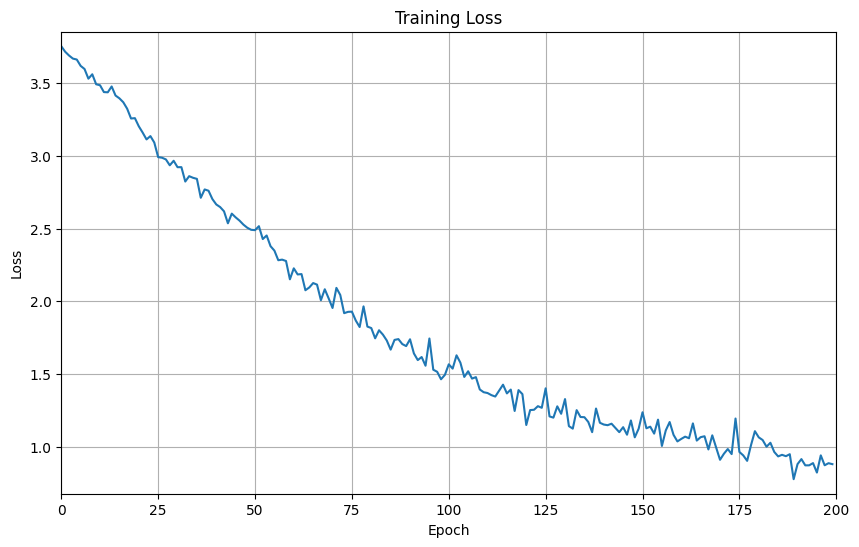

In [5]:
import torch
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

DEVICE = "cuda"
NUM_EPOCHS = 200
LEARNING_RATE = 0.0001
BATCH_SIZE = 1


plt.ion()
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Training Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_xlim(0, NUM_EPOCHS - 1)
lines, = ax.plot([], [])
ax.grid(True)


device = torch.device(DEVICE)
model = model = SeparationModel(input_dim=get_user_vector_size(), num_classes=MAX_DOS).to(device)
dataloader = DataLoader(MSDS, batch_size=BATCH_SIZE, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

losses = []  # Store loss values for plotting

for epoch in range(NUM_EPOCHS):
    total_loss = 0
    for data, target in dataloader:
        data = data.float().to(device)
        target = target.long().to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / len(dataloader)
    losses.append(average_loss)
    
    
    # Update the plot
    lines.set_xdata(list(range(epoch + 1)))
    lines.set_ydata(losses)
    ax.set_xlim(0, epoch + 1)
    ax.set_ylim(min(losses) - 0.1, max(losses) + 0.1)
    display(fig)
    clear_output(wait=True)

plt.ioff()
plt.show()

### Save the Model

In [6]:
torch.save(model,"MuSo.pth")